### Fixing decoder

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

from model import GrammarVAE
from util import Timer, AnnealKL, load_data

In [2]:
# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = 12
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE)

Using device: mps


In [9]:
batch_size = 2
x = torch.randn(batch_size, OUTPUT_SIZE, MAX_LENGTH)  # OUTPUT_SIZE: number of rules (for 1-hot encoding)
mu, sigma = model.encoder(x)
print(mu, sigma)  # z

logits = model.decoder(mu, 15)
print(logits.shape)

tensor([[ 0.1680, -0.2196],
        [ 0.1450, -0.2121]], grad_fn=<AddmmBackward0>) tensor([[0.7805, 0.7860],
        [0.8027, 0.7900]], grad_fn=<SoftplusBackward0>)
torch.Size([2, 15, 12])


In [126]:
# torch.manual_seed(0)

import model as m
from importlib import reload
import util
from grammar import GCFG
reload(m)

# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = len(GCFG.productions()) + 1  # 1-hot + numerical
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = m.GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE)  # .to(device='mps')

batch_size = 1
x = torch.randn(batch_size, OUTPUT_SIZE, MAX_LENGTH).to(model.device) * 10  # OUTPUT_SIZE: number of rules (for 1-hot encoding)
mu, sigma = model.encoder(x)
print(f'{mu = }')

rules = model.generate(mu, sample=False, max_length=15)
print(rules)

if len(rules) < 15:
    tree = util.make_nltk_tree(rules)
    print(tree)
else:
    print('Invalid. Too many rules.')

mu = tensor([[-0.1692,  0.0015]], grad_fn=<AddmmBackward0>)
[S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T]
Invalid. Too many rules.


In [89]:
tree.pprint()

(S (T 3))


### MPS?

In [124]:
next(model.parameters()).is_mps

True

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Data loading/parsing

In [144]:
data_path = '../data/equation2_15_dataset_parsed.h5'
data = load_data(data_path)
# Turn it into a float32 PyTorch Tensor
data = torch.from_numpy(data).float()

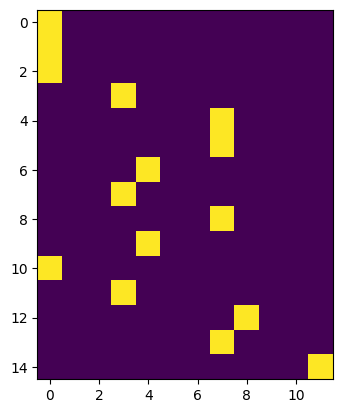

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [111]:
from matplotlib import pyplot as plt

plt.imshow(one_hot[4, ...])
plt.show()

one_hot

### Using trained model

In [3]:
import os
import torch
import sympy as sp
from torch.autograd import Variable

from model import GrammarVAE
from stack import Stack

from util import load_data, prods_to_eq
from train import ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE

torch.manual_seed(10)

# Load saved model
# model_path = os.path.abspath('../checkpoints/model5epoch.pt')
# model = torch.load(model_path)
# model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE)

# Load data
data_path = os.path.abspath('../data/equation2_15_dataset_parsed.h5')
data = load_data(data_path)

# Load raw equation strings
data_path = os.path.abspath('../data/equation2_15_dataset.txt')
with open(data_path, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

def data2input(x):
    x = torch.from_numpy(x).float().unsqueeze(0).transpose(-2, -1)
    return Variable(x)

def predict(x):
    x = data2input(x)
    logits = model(x)
    _, y = logits.squeeze(0).max(-1)
    return y

def evaluate(y, y_):
    try:
        (y == y_).mean()
    except:
        y_ = y_.data.numpy()
    return (y == y_).mean()


#### encode-decode single equation from equation file

In [24]:
from importlib import reload
import model
reload(model)
from model import GrammarVAE

In [25]:
from matplotlib import pyplot as plt
from grammar import GCFG

def plot_onehot(onehot_matrix, grammar):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    res1 = ax[0].imshow(onehot_matrix[:, :len(grammar.productions())])
    res2 = ax[1].imshow(onehot_matrix[:, len(grammar.productions()):])

    ax[0].set_ylabel('Sequence')
    ax[0].set_xlabel('Rule')
    ax[1].set_xlabel('NUM')
    xticks = grammar.productions()
    ax[0].set_xticks(range(len(xticks)), xticks, rotation='vertical')
    plt.colorbar(res1, ax=ax[0], label='Value', shrink=0.5)
    plt.colorbar(res2, ax=ax[1], label='Value', shrink=0.5)
    plt.tight_layout()
    plt.show()

In [26]:
# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = len(GCFG.productions())*2  # 1-hot for rules + numerical
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE, device='cpu')

# model_path = os.path.abspath('../checkpoints/model5epoch.pt')
# model = torch.load(model_path)

eq = 'x + x + ( 1 ) + exp( 1 / x )'
expr = 2*x + exp(1/x) + 1


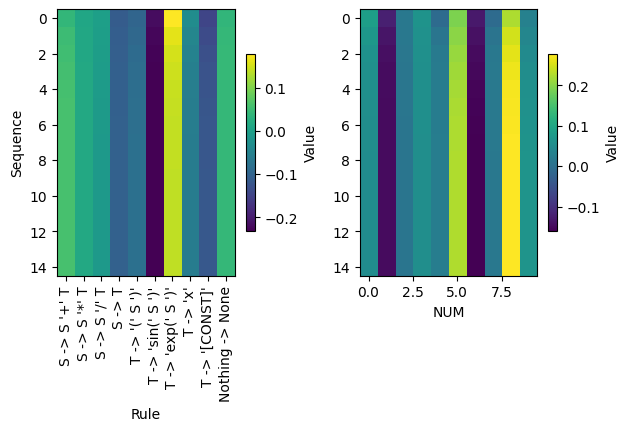

In [27]:
i = 300

eq = eqs[i]
print(f'{eq = }')
expr = sp.simplify(sp.sympify(eq))
print(f'{expr = }')

x = data2input(data[i])
mu, sigma = model.encoder(x)

logits = model.decoder(mu, max_length=15)
plot_onehot(logits[0, ...].detach().numpy(), GCFG)

In [35]:
i = 1

eq = eqs[i]
print(f'{eq = }')
expr = sp.simplify(sp.sympify(eq))
print(f'{expr = }')

x = data2input(data[i])
mu, sigma = model.encoder(x)
production, logits_nums = model.generate(mu, sample=True, max_length=15)

print(f'{production = }')
print(f'{logits_nums = }')
eq_hat = prods_to_eq(production, verbose=True)
if eq_hat:
    expr_hat = sp.simplify(sp.sympify(eq_hat))
    print(f'{expr_hat = }')



eq = 'x + x + ( x ) + ( x + 1 )'
expr = 4*x + 1
production = [S -> S '/' T, S -> S '/' T, S -> S '+' T, S -> S '*' T, S -> T, T -> 'sin(' S ')', S -> S '/' T, S -> S '+' T, S -> S '+' T, S -> T, T -> 'x', T -> '[CONST]', T -> '(' S ')', S -> S '*' T, S -> S '+' T]
logits_nums = tensor([[ 0.0856, -0.1224,  0.0153,  0.0645, -0.0067,  0.1910, -0.1299, -0.0071,
          0.2238,  0.0312],
        [ 0.0711, -0.1363,  0.0149,  0.0604,  0.0103,  0.2015, -0.1401,  0.0087,
          0.2469,  0.0402],
        [ 0.0635, -0.1425,  0.0133,  0.0585,  0.0175,  0.2095, -0.1471,  0.0143,
          0.2596,  0.0485],
        [ 0.0593, -0.1453,  0.0120,  0.0577,  0.0208,  0.2151, -0.1518,  0.0160,
          0.2668,  0.0546],
        [ 0.0567, -0.1466,  0.0111,  0.0572,  0.0226,  0.2188, -0.1549,  0.0163,
          0.2711,  0.0588],
        [ 0.0552, -0.1472,  0.0106,  0.0569,  0.0235,  0.2213, -0.1570,  0.0162,
          0.2736,  0.0617],
        [ 0.0542, -0.1476,  0.0102,  0.0568,  0.0241,  0.2229, -0.1

In [20]:
logits.shape

torch.Size([1, 15, 20])

In [84]:
import torch
from torch.autograd import Variable
from nltk import CFG, Nonterminal
from torch.distributions import Categorical

class Stack:
    """A simple first in last out stack.

    Args:
        grammar: an instance of nltk.CFG
        start_symbol: an instance of nltk.Nonterminal that is the
            start symbol the grammar
    """
    def __init__(self, grammar, start_symbol):
        self.grammar = grammar
        self._stack = [start_symbol]

    def pop(self):
        return self._stack.pop()

    def push(self, symbol):
        self._stack.append(symbol)

    def __str__(self):
        return str(self._stack)

    @property
    def nonempty(self):
        return bool(self._stack)


def get_mask(nonterminal, grammar, as_variable=False):
    if isinstance(nonterminal, Nonterminal):
        mask = [rule.lhs() == nonterminal for rule in grammar.productions()]
        mask = Variable(torch.FloatTensor(mask)) if as_variable else mask
        return mask
    else:
        raise ValueError('Input must be instance of nltk.Nonterminal')

def logits_to_prod(logits, grammar, start_symbol, sample=True, max_length=15):
    stack = Stack(grammar=grammar, start_symbol=start_symbol)

    logits_prods = logits[:, :len(grammar.productions())]
    constants = logits[:, len(grammar.productions()):]

    rules = []
    t = 0
    while stack.nonempty:
        alpha = stack.pop()
        mask = get_mask(alpha, stack.grammar, as_variable=True)
        probs = mask * logits_prods[t].exp()
        probs = probs / probs.sum()
        
        if sample:
            m = Categorical(probs)
            i = m.sample()
        else:
            _, i = probs.max(-1) # argmax

        i = i.item()
        # select rule i
        rule = stack.grammar.productions()[i]
        rules.append(rule)
        # add rhs nonterminals to stack in reversed order
        for symbol in reversed(rule.rhs()):
            if isinstance(symbol, Nonterminal):
                stack.push(symbol)
        t += 1
        if t == max_length:
            break
    return rules, constants

def prods_to_eq(prod, constants, verbose=False):
    seq = [prod[0].lhs()]  # Start with LHS of first rule (always nonterminal start)
    for prod_idx, prod in enumerate(prod):
        if str(prod.lhs()) == 'Nothing':  # Padding rule. Reached end.
            break
        consts_used = 0
        for ix, s in enumerate(seq):  # Applying rule to first element in seq that matches lhs
            if s == prod.lhs():
                # print(f'{prod.rhs() = }')
                if not prod.rhs()[0] == '[CONST]':
                    seq = seq[:ix] + list(prod.rhs()) + seq[ix+1:]  # Replace LHS with RHS
                else:
                    seq = seq[:ix] + [str(constants[prod_idx, consts_used].item())] + seq[ix+1:]  # Replace LHS with RHS but use numerical values for each [CONST] placeholder
                    consts_used += 1
                break
    try:
        return ''.join(seq)
    except TypeError:
        if verbose:
            print(f'Nonterminal found. {seq = }')
        return ''

In [85]:
grammar = """
S -> S '+' T
S -> S '*' T
S -> S '/' T
S -> T
T -> '(' S ')'
T -> 'sin(' S ')'
T -> 'exp(' S ')'
T -> 'x1'
T -> '[CONST]'
Nothing -> None"""
GCFG = CFG.fromstring(grammar)
S, T = Nonterminal('S'), Nonterminal('T')

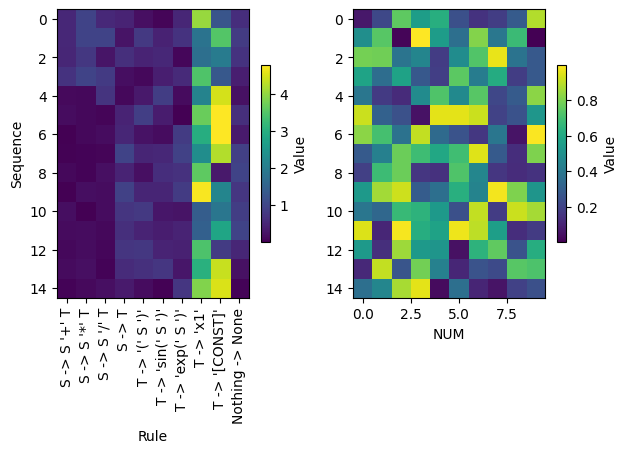

In [86]:
onehot_matrix = np.random.random([15, len(GCFG.productions())*2])
onehot_matrix[:, -13:-11] *= 5
onehot_matrix[-10:, :3] *= 0.2
plot_onehot(onehot_matrix, GCFG)

In [98]:
prods, constants = logits_to_prod(torch.tensor(onehot_matrix), GCFG, S)
eq_str = prods_to_eq(prods, constants, verbose=True)
print(f'{eq_str = }')
assert eq_str
expr = sp.sympify(eq_str)
print(f'{expr = }')

eq_str = 'x1+0.9193957004892613*0.8246553500319246*0.28611858560892567'
expr = x1 + 0.21693070057705543


### Encoding using new grammar + const

In [152]:
import re
import nltk
import numpy as np

SEQ_LEN = 15

def tokenize(s):
    funcs = ['sin', 'exp']
    for fn in funcs: s = s.replace(fn+'(', fn+' ')
    s = re.sub(r'([^a-z ])', r' \1 ', s)
    for fn in funcs: s = s.replace(fn, fn+'(')
    return s.split()

# Tokenization and parsing functions
_productions = GCFG.productions()
_tokenize = tokenize
_parser = nltk.ChartParser(GCFG)
_n_chars = len(_productions)
_prod_map = {}
for ix, prod in enumerate(_productions):
    _prod_map[prod] = ix


def onehot_encode(eqs):
    assert type(eqs) == list
    print('Starting tokenization...')
    tokens = map(_tokenize, eqs)
    print('Starting parsing...')
    parse_trees = [next(_parser.parse(t)) for t in tokens]
    print('Starting production extraction...')
    productions_seq = [tree.productions() for tree in parse_trees]

    indices = [np.array([_prod_map[prod] for prod in entry], dtype=int) for entry in productions_seq]
    print('Starting one-hot encoding...')
    one_hot = np.zeros((len(indices), SEQ_LEN, _n_chars), dtype=np.float32)
    for i in range(len(indices)):
        num_productions = len(indices[i])
        one_hot[i][np.arange(num_productions),indices[i]] = 1.
        one_hot[i][np.arange(num_productions, SEQ_LEN),-1] = 1.
    return one_hot


In [113]:
datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/expressions.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

In [180]:
eq = "0.1 * sin(0.2 + 0.3*exp(0.1*x1))+0.1"


In [196]:
s2 = "0.1 + 0.2" # "0.1 * sin(0.2 + 0.3*exp(0.1*x1))+0.1"
print(s2)

unaops = ['sin', 'exp']
binops = ['+', '-', '*', '/']
for fn in unaops: s2 = s2.replace(fn+'(', ' '+fn+'( ')
for fn in binops: s2 = s2.replace(fn, ' '+fn+' ')
s2 = s2.replace(')', ' )')
tokens = s2.split()
print(tokens)

# constants = np.zeros(SEQ_LEN, len(GCFG.productions()))
cnst = []
for i in range(len(tokens)):
    a = re.findall(r'\b\d+(?:\.\d+)?\b', tokens[i])
    if a:
        cnst.append(a[0])
        tokens[i] = '[CONST]'
print(tokens, cnst)


0.1 + 0.2
['0.1', '+', '0.2']
['[CONST]', '+', '[CONST]'] ['0.1', '0.2']


In [197]:
parse_trees = next(_parser.parse(tokens))
productions_seq = parse_trees.productions()

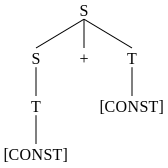

In [198]:
parse_trees

In [199]:
productions_seq

[S -> S '+' T, S -> T, T -> '[CONST]', T -> '[CONST]']

In [124]:
expr = sp.sympify(eqs[1])
symbols = [str(symbol) for symbol in expr.atoms(sp.Symbol)]
constants = [str(constant) for constant in expr.atoms(sp.Number)]
operators = [str(op) for op in expr.atoms(sp.Function)]
all_symbols = symbols + constants + operators
print(all_symbols)

['x1', '0.4609526466213322', 'exp(0.4609526466213322*sin(x1))', 'sin(exp(0.4609526466213322*sin(x1)))', 'sin(x1)']


In [125]:
operators

['exp(0.4609526466213322*sin(x1))',
 'sin(exp(0.4609526466213322*sin(x1)))',
 'sin(x1)']

In [133]:
s = "1 / 2 + exp( sin ( 2 ) ) + ( 3 )"

funcs = ['sin', 'exp']
for fn in funcs: s = s.replace(fn+'(', fn+' ')
print(s)
s = re.sub(r'([^a-z ])', r' \1 ', s)
print(s)
for fn in funcs: s = s.replace(fn, fn+'(')
print(s)
print(s.split())


1 / 2 + exp  sin ( 2 ) ) + ( 3 )
 1   /   2   +  exp  sin  (   2   )   )   +   (   3   ) 
 1   /   2   +  exp(  sin(  (   2   )   )   +   (   3   ) 
['1', '/', '2', '+', 'exp(', 'sin(', '(', '2', ')', ')', '+', '(', '3', ')']


In [107]:
len(tokens)

53322

In [110]:
datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/grammar-vae/data/equation2_15_dataset.txt'
# parsed_path = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/grammar-vae/data/equation2_15_dataset_parsed.h5'

with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

tokens = list(map(_tokenize, eqs))

In [112]:
eqs[0]

'x + x + ( x ) + ( x + x )'